In [1]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

from scripts_fermions.operators import Hamiltonian, Boost
import yastn
from yastn.tn import mps

In [2]:
g = 1
v, Q = 1, 1
N = 512
D = 512
a = 0.0625
m = 0
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/P=*/**/state_t=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fns = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", "dt=0.0625", f"{N=}", f"{D=}", f"{a=:0.4f}", f"{m=:0.4f}"])]);

In [3]:
#
D = 128
ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*_boosted.npy")
fnames = glob.glob(glob_path, recursive=True)
fbt = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{m=:0.4f}"])])
#
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items())][0]
#
d_ex = np.load(fn_mass(fex ), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs ), allow_pickle=True).item()
d_boost = np.load(fn_mass(fbt), allow_pickle=True).item()


In [33]:
fex

['/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/ex/state_D=128.npy',
 '/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=512/a=0.0625/ex/state_D=128_boosted.npy']

In [4]:
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()
psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

H = Hamiltonian(N, m, g, t=0, a=a, v=1, Q=0, ops=ops)
K = Boost(N, m, g, a, ops)

E_ex = mps.vdot(psi_ex, H, psi_ex).real
E_gs = mps.vdot(psi_gs, H, psi_gs).real

In [5]:
ts = np.linspace(0, 16, 17)
Ps = [0, 1, 2, 4, 6, 8]
psi_t = {(t, P): yastn.from_dict(np.load(fn_mass(fns, t=t, P=P), allow_pickle=True).item()['psi']) for t in ts for P in Ps}
chis = [x for x in d_boost['chis'] if x <= 2]
psi_chi = {chi: yastn.from_dict(d_boost['psi'][ii]) for ii, chi in enumerate(chis)}


In [ ]:
probs = {}
for (t, P), pt in psi_t.items():
    print(t, P)
    for chi, pc in psi_chi.items():
        if (t, P, chi) not in probs:
            probs[t, P, chi] = np.abs(mps.vdot(pt, pc)) ** 2


In [7]:
np.save(f"./results_fermions/probs_gauss_{m=}.npy", probs, allow_pickle=True)
probs = np.load(f"./results_fermions/probs_gauss_{m=}.npy", allow_pickle=True).item()

In [8]:
probs_gs = {(t, PP): np.abs(mps.vdot(pt, psi_gs)) ** 2 for (t, PP), pt in psi_t.items()}

In [9]:
np.save(f"./results_fermions/probs_gs_gauss_{m=}.npy", probs_gs, allow_pickle=True)
probs_gs = np.load(f"./results_fermions/probs_gs_gauss_{m=}.npy", allow_pickle=True).item()

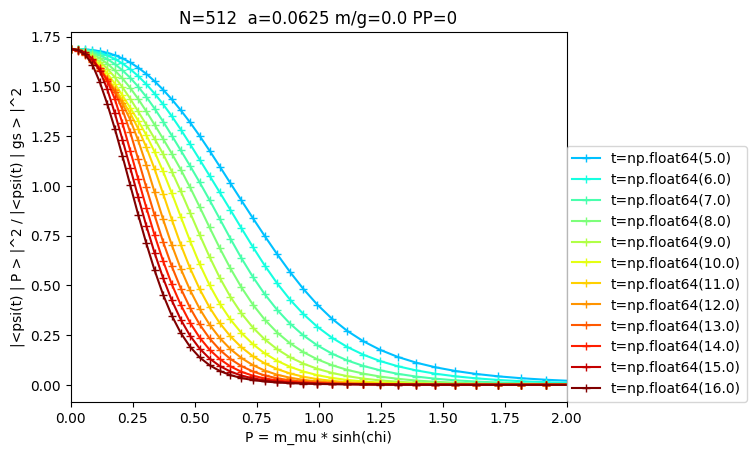

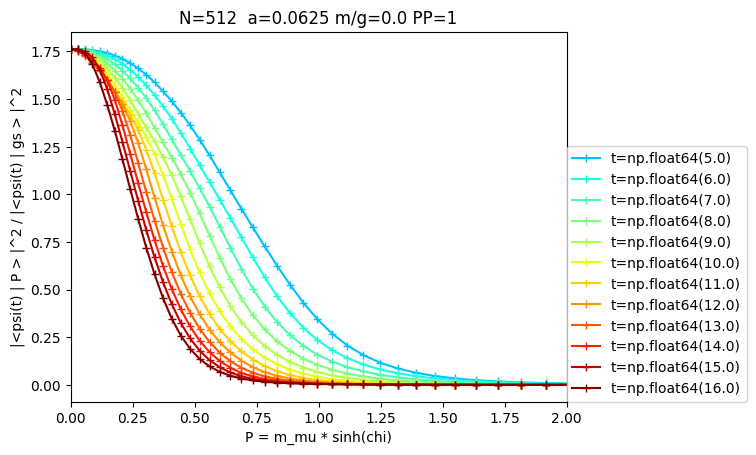

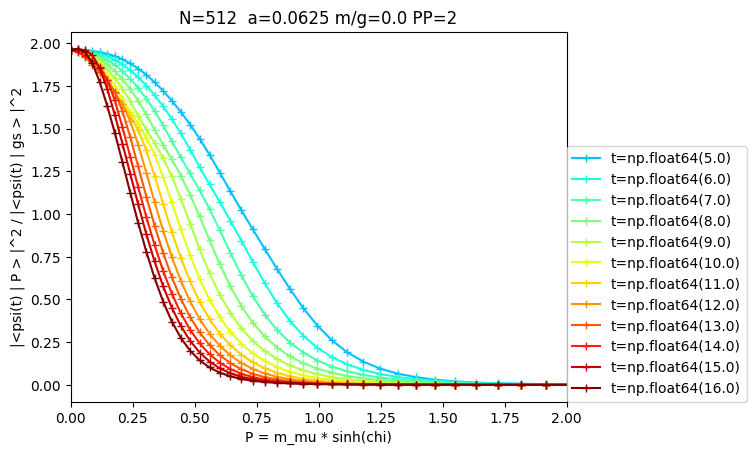

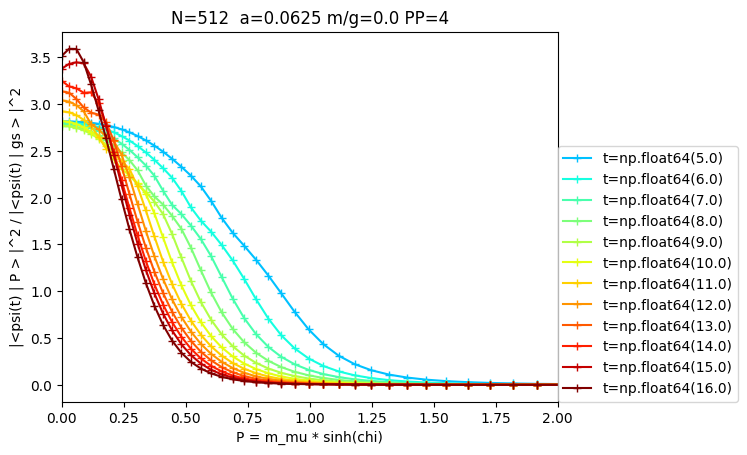

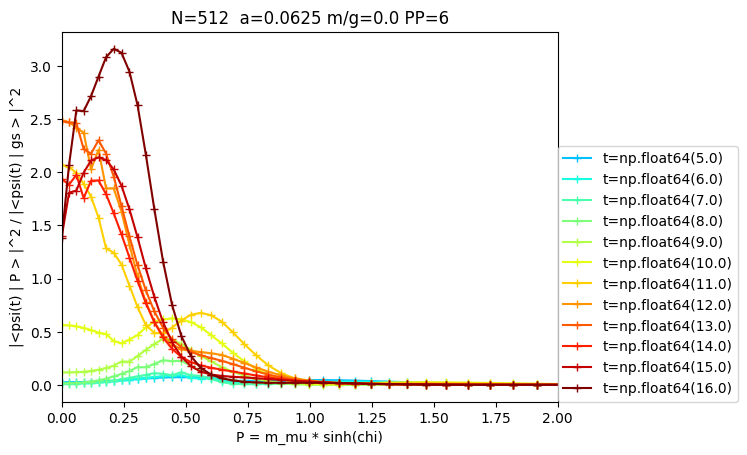

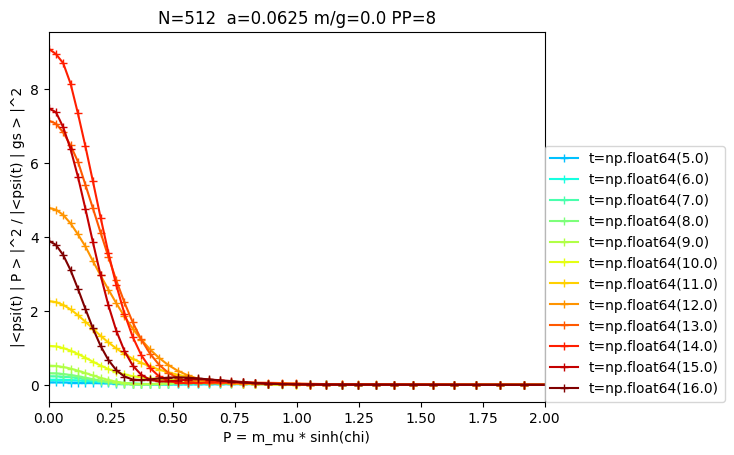

In [10]:
cm = plt.cm.jet
for PP in Ps:
    for t in ts[5:]:
        pr = [probs[t, PP, chi] / probs_gs[t, PP] for chi in chis]
        P = np.sinh(chis) * (E_ex - E_gs)
        plt.plot(P, pr, '-+', label=f"{t=}", color = cm(t / ts[-1]))
    plt.xlabel('P = m_mu * sinh(chi)')
    plt.ylabel("|<psi(t) | P > |^2 / |<psi(t) | gs > |^2")
    plt.legend(loc=(1, 0))
    plt.xlim([0, 2])
    plt.title(f"N=512  a=0.0625 {m/g=} {PP=}")
    #plt.ylim([1e-3, 1e1])
    plt.show()

In [ ]:
# TEST INITIAL STATE

from scripts_fermions.operators import fermionP, measure_local_observables

Ps = np.linspace(0, 10, 41)
entot = np.zeros_like(Ps)
T01half = np.zeros_like(Ps)
j0half = np.zeros_like(Ps)
j1tot = np.zeros_like(Ps)


ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')

for i, PP in enumerate(Ps[30:], start=30):
    fermionR = fermionP(N, a, PP, 1.5, 0.25, 'cp', parity=0, ops=ops)
    fermionL = fermionP(N, a, -PP, -1.5, 0.25, 'cm', parity=1, ops=ops)
    psiP = fermionL @ fermionR @ psi_gs
    psiP = psiP / psiP.norm()

    T00r, T11r, T01r, j0r, j1r, nur, Lnr = measure_local_observables(psiP, 0, a, g, m, v, 0, ops)

    entot[i] = a*np.sum(T00r-d_gs['T00'])
    T01half[i] = a*np.sum((T01r-d_gs['T01'])[N//2:])
    j0half[i] = 2*a*np.sum((j0r-d_gs['j0'])[N//4:])
    j1tot[i] = 2*a*np.sum(j1r-d_gs['j1'])


(0.0, 20.9787562045572)

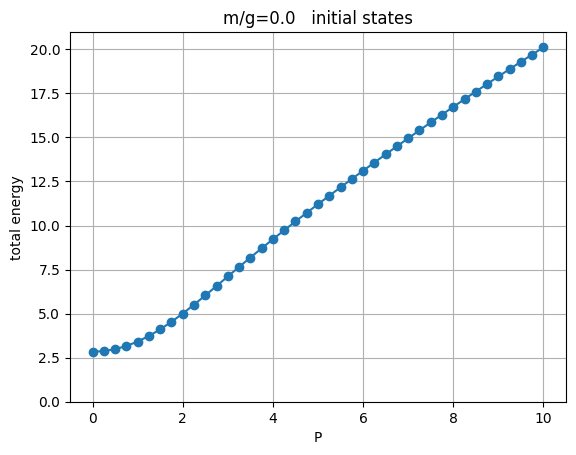

In [21]:
plt.figure()
plt.plot(Ps, entot, 'o-')
plt.xlabel('P')
plt.ylabel('total energy')
plt.title('m/g={:.1f}   initial states'.format(m/g))
plt.grid()
plt.ylim(bottom=0)
#plt.savefig('initial_states_entot.png')

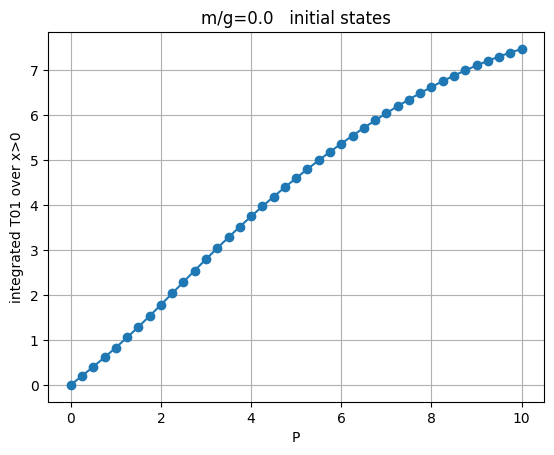

In [22]:
plt.figure()
plt.plot(Ps, T01half, 'o-')
plt.xlabel('P')
plt.ylabel('integrated T01 over x>0')
plt.title('m/g={:.1f}   initial states'.format(m/g))
plt.grid()
#plt.savefig('initial_states_T01half.png')

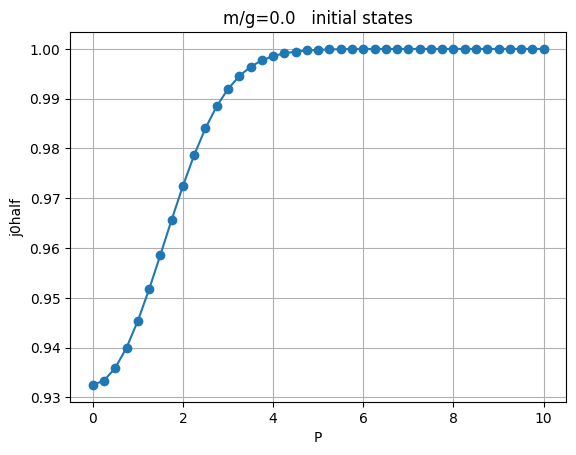

In [24]:
plt.figure()
plt.plot(Ps, j0half, 'o-')
plt.xlabel('P')
plt.ylabel('j0half')
plt.title('m/g={:.1f}   initial states'.format(m/g))
plt.grid()
#plt.ylim(bottom=0)
#plt.savefig('initial_states_j0half.png')

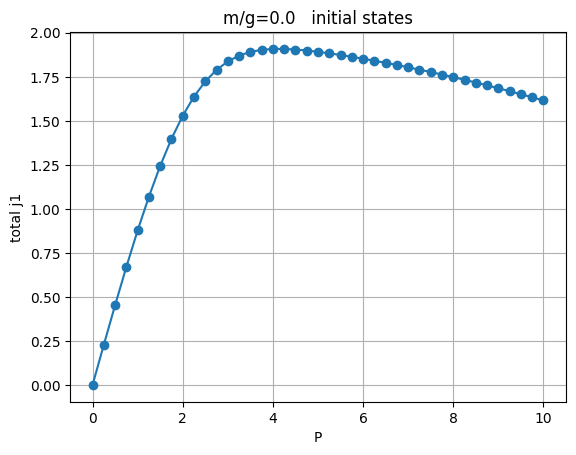

In [25]:
plt.figure()
plt.plot(Ps, j1tot, 'o-')
plt.xlabel('P')
plt.ylabel('total j1')
plt.title('m/g={:.1f}   initial states'.format(m/g))
plt.grid()
plt.savefig('initial_states_j1tot.png')

In [ ]:
# BANULS STATE

def ap1(P, N=N, a=a):
    terms =  [mps.Hterm( 1j * np.exp(1j*a*P*n)/ (2 * a), [n + 1, n], [ops.cp(), ops.c()]) for n in range(N-1)]
    terms += [mps.Hterm( 1j * np.exp(1j*a*P*n)/ (2 * a), [n, n + 1], [ops.cp(), ops.c()]) for n in range(N-1)]
    op = mps.generate_mpo(ops.I(), terms, N=N)
    return op

psi_banuls = ap1(0) @ psi_gs

probs_banuls = {(t, PP): np.abs(mps.vdot(pt, psi_banuls)) ** 2 for (t, PP), pt in psi_t.items()}

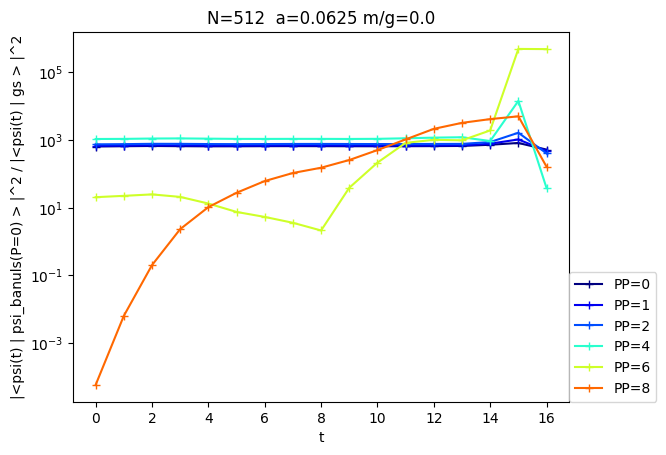

In [41]:
cm = plt.cm.jet
for PP in [0, 1, 2, 4, 6, 8]:
    pr = [probs_banuls[t, PP] / probs_gs[t, PP] for t in ts]
    plt.semilogy(ts, pr, '-+', label=f"{PP=}", color = cm(PP / Ps[-1]))
    plt.xlabel('t')
    plt.ylabel("|<psi(t) | psi_banuls(P=0) > |^2 / |<psi(t) | gs > |^2")
    plt.legend(loc=(1, 0))
    #plt.xlim([0, 2])
    plt.title(f"N=512  a=0.0625 {m/g=}")
    #plt.ylim([1e-3, 1e2])
